In [ ]:
import pandas as pd
import gzip
import json
import os
import jq
from collections import defaultdict
import re

from pathlib import Path

In [ ]:
p = Path('../2-9.playwright/output/')
oses = ['mac', 'win', 'linux']
imr = Path('imr')
for os in oses:
    (imr / f'raf-{os}').mkdir(parents=True, exist_ok=True)

In [ ]:
# def extract_hlsl(s):
#     pattern = r"// INITIAL HLSL BEGIN\n*(.*?)\n*// INITIAL HLSL END"
#     match = re.search(pattern, s, re.DOTALL)

#     if match:
#         return match.group(1)
#     else:
#         return None
# extract_hlsl("aaa// INITIAL HLSL BEGIN\nbbb\n// INITIAL HLSL ENDccc")

In [ ]:
# results = defaultdict(dict)
# for os in oses:
#     for path in (imr / f'raf-{os}').glob('*.json'):
#         try:
#             tmp = json.loads(path.read_text())
#             sources = jq.compile('.. | objects | select(.source?) | .source').input(text=json.dumps(tmp)).all()
#             translatedSources = jq.compile('.. | objects | select(.translatedSource?) | .translatedSource').input(text=json.dumps(tmp)).all()
#             if os == 'win':
#                 translatedSources = [extract_hlsl(s) for s in translatedSources]
#             results[path.stem][os] = {
#                 'sources': sources,
#                 'translatedSources': translatedSources
#             }
#         except Exception as e:
#             print(path)
#             pass

In [ ]:
# sources = jq.compile('.frame.gl_rafs[].value.data.contextInfo[].maghsk | {shaders, programs}').input(text=path.read_text()).all()
# shaders_list = []
# global_program_id = 0
# for context_id, context in enumerate(sources):
#     tmp = {}
#     for shader in context['shaders']:
#         tmp[shader['id']] = {
#             'idx_url': path.stem,
#             'idx_context': context_id,
#             'idx_program': None,
#             'source': shader['source'],
#             'translatedSource': shader['translatedSource'] if os != 'win' else extract_hlsl(shader['translatedSource']),
#             'type': 'vertex' if shader['type'] == 35633 else 'fragment',
#         }
#     for program in context['programs']:
#         for x in program['shaders']:
#             tmp[x]['idx_program'] = global_program_id
#         global_program_id += 1
#     shaders_list.extend(tmp.values())

In [ ]:
df = pd.read_pickle('imr/translated_shader_preproc.pkl.zst', compression='zstd').dropna(subset=['source']).explode('source')

In [ ]:
df

In [ ]:
df[df.source.map(lambda x: type(x) != str)]

In [ ]:
df.source.astype('str').str.len().min()

In [ ]:
df

In [ ]:
vertex_sources_unique = sorted(df[df['type']=='vertex'].source.unique(), key=lambda x: len(x))
fragment_sources_unique = sorted(df[df['type']=='fragment'].source.unique(), key=lambda x: len(x))

In [ ]:
vertex_sources_unique

In [ ]:
fragment_sources_unique

In [ ]:
df_win = df[df.os == 'win']
df_linux = df[df.os == 'linux']
df_mac = df[df.os == 'mac']

In [ ]:
df_win_translen = df_win.translatedSource.astype('str').str.len()
df_linux_translen = df_linux.translatedSource.astype('str').str.len()
df_mac_translen = df_mac.translatedSource.astype('str').str.len()

In [105]:
# plot three histograms in one plot
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np
import seaborn as sns

sns.set_style('whitegrid')
sns.set_context('paper', font_scale=2)

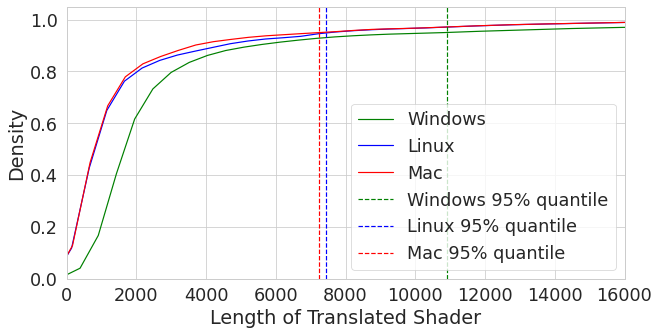

In [114]:
fig, ax = plt.subplots(figsize=(10, 5))
# 绘制三个系列的直方图
sns.kdeplot(df_win_translen, ax=ax, color='green', label='Windows', cumulative=True)
sns.kdeplot(df_linux_translen, ax=ax, color='blue', label='Linux', cumulative=True)
sns.kdeplot(df_mac_translen, ax=ax, color='red', label='Mac', cumulative=True)
# 设置图例
ax.set_xlim(0, 16000)
ax.set_xlabel('Length of Translated Shader')
# show 0.95 quantile
ax.axvline(df_win_translen.quantile(0.95), color='green', linestyle='--', label='Windows 95% quantile')
ax.axvline(df_linux_translen.quantile(0.95), color='blue', linestyle='--', label='Linux 95% quantile')
ax.axvline(df_mac_translen.quantile(0.95), color='red', linestyle='--', label='Mac 95% quantile')
# custom_legend_item = mlines.Line2D([], [], color='black', linestyle='--', label='Density Line')

# 添加自定义图例项到图例
# ax.legend(handles=[custom_legend_item])
# set legend position
ax.legend(loc='lower right')
# ax.legend()
# 显示图形
plt.savefig('fig/results_shader_translated_shader_len.pdf', bbox_inches='tight')